https://data.world/amitkishore/can-you-predict-products-back-order

---



In [ ]:
# Description:
# sku – Random ID for the product
# national_inv – Current inventory level for the part
# lead_time – Transit time for product (if available)
# in_transit_qty – Amount of product in transit from source
# forecast_3_month – Forecast sales for the next 3 months
# forecast_6_month – Forecast sales for the next 6 months
# forecast_9_month – Forecast sales for the next 9 months
# sales_1_month – Sales quantity for the prior 1 month time period
# sales_3_month – Sales quantity for the prior 3 month time period
# sales_6_month – Sales quantity for the prior 6 month time period
# sales_9_month – Sales quantity for the prior 9 month time period
# min_bank – Minimum recommend amount to stock
# potential_issue – Source issue for part identified
# pieces_past_due – Parts overdue from source
# perf_6_month_avg – Source performance for prior 6 month period
# perf_12_month_avg – Source performance for prior 12 month period
# local_bo_qty – Amount of stock orders overdue
# deck_risk – Part risk flag
# oe_constraint – Part risk flag
# ppap_risk – Part risk flag
# stop_auto_buy – Part risk flag
# rev_stop – Part risk flag
# went_on_backorder – Product actually went on backorder. This is the target value.

Objective meningkatkan kemampuan deteksi barang back order sehrta mengurangi lead time

In [2]:
!pip install dalex
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=37e208c3b73e02620cda0dab4653efcbde88a56c09d9258e6a2423e969082f58
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


#Instal Pack


In [3]:
# import pandas for data wrangling
import pandas as pd
# import numpy for vectorize data manipulation
import numpy as np
# import matplotlib.pyplot module for data visualization
import matplotlib.pyplot as plt
# import seaborn for data visualization
import seaborn as sns
# import scipy for certain statistical function
from scipy import stats

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Classification
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, classification_report, roc_auc_score

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

#Forcasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# load scikit-plot modules
import scikitplot as skplt
# import dalex to explain complex model
import dalex as dx


#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:

#df2=pd.read_csv('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /Kaggle_Training_Dataset_v2.csv')
#after impute knn (2hour)
df=pd.read_csv('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /imputed_dataset.csv')

test_df=pd.read_csv('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /Kaggle_Test_Dataset_v2.csv')
pd.set_option('display.max_columns', None)

<ipython-input-4-07ca5bf07102>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df=pd.read_csv('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /Kaggle_Test_Dataset_v2.csv')


In [ ]:
#Hyper inbalance precision setidak termasuk berapa persen data tersebut, recall diatas 50%

In [ ]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [ ]:
df.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


In [ ]:
df[df['national_inv']<0]

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,inv_to_sales_1_month,inv_to_sales_3_month,inv_to_sales_6_month,inv_to_sales_9_month,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,lead_time_category,LTD
176,-55.0,8.0,2.0,25.0,100.0,205.0,387.0,52.0,No,0.0,-99.00,-99.00,56.0,No,No,No,Yes,No,Yes,-2.200000,-0.550000,-0.268293,-0.142119,0.250000,0.487805,0.529716,-0.036364,-99.000,179.25,1,1434.00
191,-499.0,12.0,350.0,747.0,2550.0,3572.0,4745.0,401.0,No,0.0,0.49,0.72,525.0,No,No,No,Yes,No,Yes,-0.668005,-0.195686,-0.139698,-0.105163,0.292941,0.713886,0.752792,-0.701403,0.605,2903.50,1,34842.00
342,-48.0,8.0,97.0,19.0,87.0,165.0,199.0,14.0,No,0.0,0.47,0.47,60.0,Yes,No,No,Yes,No,No,-2.526316,-0.551724,-0.290909,-0.241206,0.218391,0.527273,0.829146,-2.020833,0.470,117.50,1,940.00
552,-1.0,12.0,0.0,0.0,1.0,2.0,2.0,0.0,No,0.0,0.82,0.79,1.0,No,No,No,Yes,No,No,0.000000,-1.000000,-0.500000,-0.500000,0.000000,0.500000,1.000000,-0.000000,0.805,1.25,1,15.00
916,-94.0,9.0,80.0,205.0,205.0,205.0,205.0,0.0,No,0.0,0.91,0.74,0.0,No,No,No,Yes,No,No,-0.458537,-0.458537,-0.458537,-0.458537,1.000000,1.000000,1.000000,-0.851064,0.825,205.00,1,1845.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687847,-206.0,8.0,0.0,114.0,853.0,1764.0,2706.0,0.0,No,0.0,-99.00,-99.00,206.0,Yes,No,No,Yes,No,No,-1.807018,-0.241501,-0.116780,-0.076127,0.133646,0.483560,0.651885,-0.000000,-99.000,1359.25,1,10874.00
1687850,-2.0,8.0,0.0,6.0,32.0,46.0,57.0,2.0,No,0.0,-99.00,-99.00,32.0,Yes,No,No,No,No,No,-0.333333,-0.062500,-0.043478,-0.035088,0.187500,0.695652,0.807018,-0.000000,-99.000,35.25,1,282.00
1687851,-6.0,9.0,36.0,0.0,0.0,54.0,57.0,3.0,No,0.0,0.03,0.10,42.0,No,No,No,Yes,No,No,0.000000,0.000000,-0.111111,-0.105263,0.000000,0.000000,0.947368,-6.000000,0.065,27.75,1,249.75
1687856,-1.0,8.0,0.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No,-1.000000,-0.333333,-0.333333,-0.125000,0.333333,1.000000,0.375000,-0.000000,-99.000,3.75,1,30.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [ ]:
df.shape

(1687861, 23)

In [ ]:
test_df.shape

(242076, 23)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sku                242076 non-null  object 
 1   national_inv       242075 non-null  float64
 2   lead_time          227351 non-null  float64
 3   in_transit_qty     242075 non-null  float64
 4   forecast_3_month   242075 non-null  float64
 5   forecast_6_month   242075 non-null  float64
 6   forecast_9_month   242075 non-null  float64
 7   sales_1_month      242075 non-null  float64
 8   sales_3_month      242075 non-null  float64
 9   sales_6_month      242075 non-null  float64
 10  sales_9_month      242075 non-null  float64
 11  min_bank           242075 non-null  float64
 12  potential_issue    242075 non-null  object 
 13  pieces_past_due    242075 non-null  float64
 14  perf_6_month_avg   242075 non-null  float64
 15  perf_12_month_avg  242075 non-null  float64
 16  lo

In [ ]:
test_df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


In [ ]:
df.isna().sum()

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

In [ ]:
df.isna().sum()*100/len(df)

sku                  0.000000
national_inv         0.000059
lead_time            5.977625
in_transit_qty       0.000059
forecast_3_month     0.000059
forecast_6_month     0.000059
forecast_9_month     0.000059
sales_1_month        0.000059
sales_3_month        0.000059
sales_6_month        0.000059
sales_9_month        0.000059
min_bank             0.000059
potential_issue      0.000059
pieces_past_due      0.000059
perf_6_month_avg     0.000059
perf_12_month_avg    0.000059
local_bo_qty         0.000059
deck_risk            0.000059
oe_constraint        0.000059
ppap_risk            0.000059
stop_auto_buy        0.000059
rev_stop             0.000059
went_on_backorder    0.000059
dtype: float64

In [ ]:
df.duplicated().sum()

0

#Cleaning

In [5]:
df['perf_6_month_avg'] = df['perf_6_month_avg'].replace(-99, df['perf_6_month_avg'][df['perf_6_month_avg'] != -99].mean())
df['perf_12_month_avg'] = df['perf_12_month_avg'].replace(-99, df['perf_12_month_avg'][df['perf_12_month_avg'] != -99].mean())

In [ ]:
df.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,2.094460e+06,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,7.823812e-01,7.769763e-01,6.264507e-01
std,6.730819e+05,2.961523e+04,6.841885e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.277419e-01,2.220005e-01,3.372224e+01
min,1.026827e+06,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.533484e+06,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.300000e-01,7.200000e-01,0.000000e+00
50%,1.955448e+06,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,2.862954e+06,8.000000e+01,8.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,3.284919e+06,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


In [ ]:
df[df['national_inv'].isna()]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop(1687860)

In [ ]:
df.isna().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687860 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [ ]:
#KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
df['lead_time'] = imputer.fit_transform(df[['lead_time']])

In [ ]:
df.isna().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [14]:
output_file_path = '/content/drive/My Drive/DS 24_Satrio Bayu_Progress Final Project /cleaned_dataset.csv'
df.to_csv(output_file_path, index=False)


In [ ]:
df['lead_time'].median(), df['lead_time'].mean()

(8.0, 7.879902361570273)

In [ ]:
df2 = df2.drop(1687860)
df2['lead_time'].fillna(df2['lead_time'].mean(), inplace = True)

In [ ]:
#df['lead_time'].fillna(0, inplace=True)

#Feature Add

In [6]:
# #rumus penting
# Akurasi inventaris digunakan untuk menghitung keakuratan inventaris Anda.
# Rumus: (# item dihitung) / (# item dihitung buku)

# Total waktu siklus pesanan mencerminkan jangka waktu rata-rata yang berlalu antara
# pelanggan yang melakukan pemesanan dan pesanan dikirimkan.
# Rumus: (waktu pesanan diterima pelanggan – waktu pemesanan dilakukan) / (jumlah total pesanan dikirimkan)



## Sales

In [7]:
#Trend Sales
df['sales_trend_1_to_3'] = np.where(df['sales_3_month'] != 0, df['sales_1_month'] / df['sales_3_month'], 0)
df['sales_trend_3_to_6'] = np.where(df['sales_6_month'] != 0, df['sales_3_month'] / df['sales_6_month'], 0)
df['sales_trend_6_to_9'] = np.where(df['sales_9_month'] != 0, df['sales_6_month'] / df['sales_9_month'], 0)


##Transit

In [8]:
 df['in_transit_to_inventory'] =np.where(df['national_inv'] != 0, df['in_transit_qty'] / df['national_inv'], 0)

##AVG Perform

In [9]:
df['avg_performance'] = (df['perf_6_month_avg'] + df['perf_12_month_avg']) / 2

##Demand Variability

In [10]:
df['demand_variability'] = (df['sales_1_month'] + df['sales_3_month'] + df['sales_6_month'] + df['sales_9_month']) / 4

## Lead Time category

In [11]:
# def categorize_lead_time(lead_time):
#     if lead_time <= 7:
#         return 'very_short'
#     elif lead_time <= 14:
#         return 'short'
#     elif lead_time <= 30:
#         return 'medium'
#     else:
#         return 'long'

# df['lead_time_category'] = df['lead_time'].apply(categorize_lead_time)

##Lead TIme Demand

In [12]:
df['LTD']=df['lead_time']*df['demand_variability']

#EDA

#Statical Sumarry

In [ ]:
df.head(1)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD
0,1026827,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No,0.0,0.0,0.0,0.0,-99.0,0.0,0.0


In [13]:
df.drop(columns = ['sku', 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month'], inplace = True)
#after check multico
df.drop(columns =['sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month','perf_6_month_avg',
 'perf_12_month_avg'], inplace=True)

In [ ]:
categorical = df.select_dtypes(include=['object','category']).columns.tolist()
numerical = df.select_dtypes(include=['int','float']).columns.tolist()

In [ ]:
categorical

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop',
 'went_on_backorder']

In [ ]:
numerical

['national_inv',
 'lead_time',
 'in_transit_qty',
 'min_bank',
 'pieces_past_due',
 'local_bo_qty',
 'sales_trend_1_to_3',
 'sales_trend_3_to_6',
 'sales_trend_6_to_9',
 'in_transit_to_inventory',
 'avg_performance',
 'demand_variability',
 'LTD']

##numerical

In [ ]:
#df[numerical].describe()

In [ ]:
df[numerical].describe()

,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD
count,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,5.277230e+01,2.043724e+00,6.264507e-01,1.705916e-01,3.097138e-01,4.373156e-01,1.369414e-01,-6.655003e+00,2.744876e+02,1.781883e+03
std,2.961523e+04,6.841885e+00,1.342742e+03,1.254983e+03,2.360165e+02,3.372224e+01,2.482015e-01,3.236789e-01,3.755450e-01,1.968283e+01,2.599482e+01,7.739512e+03,5.436003e+04
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.440000e+03,-9.900000e+01,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.600000e-01,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.333333e-01,5.652174e-01,0.000000e+00,8.150000e-01,2.000000e+00,1.125000e+01
75%,8.000000e+01,8.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,3.090909e-01,5.263158e-01,7.142857e-01,0.000000e+00,9.550000e-01,2.425000e+01,1.590000e+02
max,1.233440e+07,5.200000e+01,4.894080e+05,3.133190e+05,1.464960e+05,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.967400e+04,1.000000e+00,1.700976e+06,1.360781e+07


In [ ]:
df[numerical].describe()

,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD
count,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,5.277230e+01,2.043724e+00,6.264507e-01,1.705916e-01,3.097138e-01,4.373156e-01,1.369414e-01,-6.655003e+00,2.744876e+02,1.781883e+03
std,2.961523e+04,6.841885e+00,1.342742e+03,1.254983e+03,2.360165e+02,3.372224e+01,2.482015e-01,3.236789e-01,3.755450e-01,1.968283e+01,2.599482e+01,7.739512e+03,5.436003e+04
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.440000e+03,-9.900000e+01,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.600000e-01,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.333333e-01,5.652174e-01,0.000000e+00,8.150000e-01,2.000000e+00,1.125000e+01
75%,8.000000e+01,8.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,3.090909e-01,5.263158e-01,7.142857e-01,0.000000e+00,9.550000e-01,2.425000e+01,1.590000e+02
max,1.233440e+07,5.200000e+01,4.894080e+05,3.133190e+05,1.464960e+05,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.967400e+04,1.000000e+00,1.700976e+06,1.360781e+07


National inv,Avg peformance,in_transit_to_inventory

### cek suspect value

In [ ]:
df[df['national_inv'] < 0].head

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
176,1111655,-55.0,8.000000,2.0,428.0,526.0,606.0,25.0,100.0,205.0,387.0,52.0,No,0.0,-99.00,-99.00,56.0,No,No,No,Yes,No,Yes
191,1111670,-499.0,12.000000,350.0,3452.0,5044.0,7188.0,747.0,2550.0,3572.0,4745.0,401.0,No,0.0,0.49,0.72,525.0,No,No,No,Yes,No,Yes
342,1111821,-48.0,8.000000,97.0,67.0,85.0,115.0,19.0,87.0,165.0,199.0,14.0,No,0.0,0.47,0.47,60.0,Yes,No,No,Yes,No,No
552,1112031,-1.0,12.000000,0.0,6.0,6.0,6.0,0.0,1.0,2.0,2.0,0.0,No,0.0,0.82,0.79,1.0,No,No,No,Yes,No,No
916,1112396,-94.0,9.000000,80.0,5.0,8.0,8.0,205.0,205.0,205.0,205.0,0.0,No,0.0,0.91,0.74,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687847,1375861,-206.0,7.872267,0.0,760.0,1145.0,1453.0,114.0,853.0,1764.0,2706.0,0.0,No,0.0,-99.00,-99.00,206.0,Yes,No,No,Yes,No,No
1687850,1446671,-2.0,7.872267,0.0,0.0,62.0,86.0,6.0,32.0,46.0,57.0,2.0,No,0.0,-99.00,-99.00,32.0,Yes,No,No,No,No,No
1687851,1373539,-6.0,9.000000,36.0,130.0,130.0,130.0,0.0,0.0,54.0,57.0,3.0,No,0.0,0.03,0.10,42.0,No,No,No,Yes,No,No
1687856,1373987,-1.0,7.872267,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No


In [ ]:
(df['national_inv'] < 0).sum()

5888

In [ ]:
df[df['perf_6_month_avg'] < 0].head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
2,1043696,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
4,1044048,8.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
6,1044643,1095.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
8,1045815,140.0,7.872267,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No


In [ ]:
(df['perf_6_month_avg'] < 0).sum()

129478

In [ ]:
df[df['perf_12_month_avg'] < 0].head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
2,1043696,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
4,1044048,8.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
6,1044643,1095.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
8,1045815,140.0,7.872267,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No


In [ ]:
(df['perf_12_month_avg'] < 0).sum()

122050

##Categorical

In [ ]:
 for i in categorical:
  print(f"Value counts of {i} column")
  print(df[i].value_counts(), '\n')

Value counts of potential_issue column
potential_issue
No     1686953
Yes        907
Name: count, dtype: int64 

Value counts of deck_risk column
deck_risk
No     1300377
Yes     387483
Name: count, dtype: int64 

Value counts of oe_constraint column
oe_constraint
No     1687615
Yes        245
Name: count, dtype: int64 

Value counts of ppap_risk column
ppap_risk
No     1484026
Yes     203834
Name: count, dtype: int64 

Value counts of stop_auto_buy column
stop_auto_buy
Yes    1626774
No       61086
Name: count, dtype: int64 

Value counts of rev_stop column
rev_stop
No     1687129
Yes        731
Name: count, dtype: int64 

Value counts of went_on_backorder column
went_on_backorder
No     1676567
Yes      11293
Name: count, dtype: int64 



#Boxplot Outlier

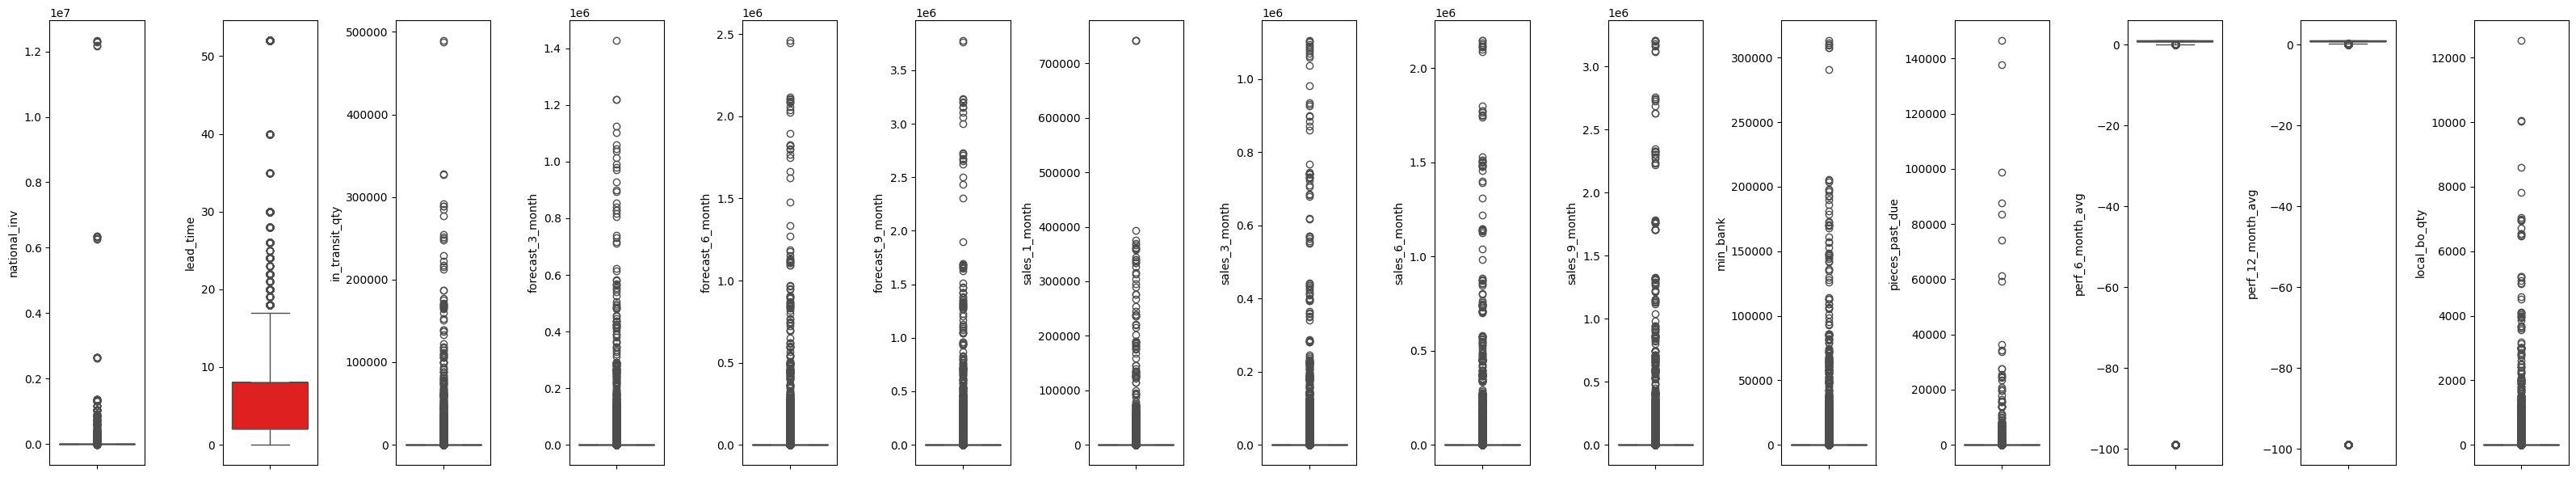

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(32,6))

# plotting
features = numerical
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='red',notch=True,vert=True)
    plt.tight_layout()

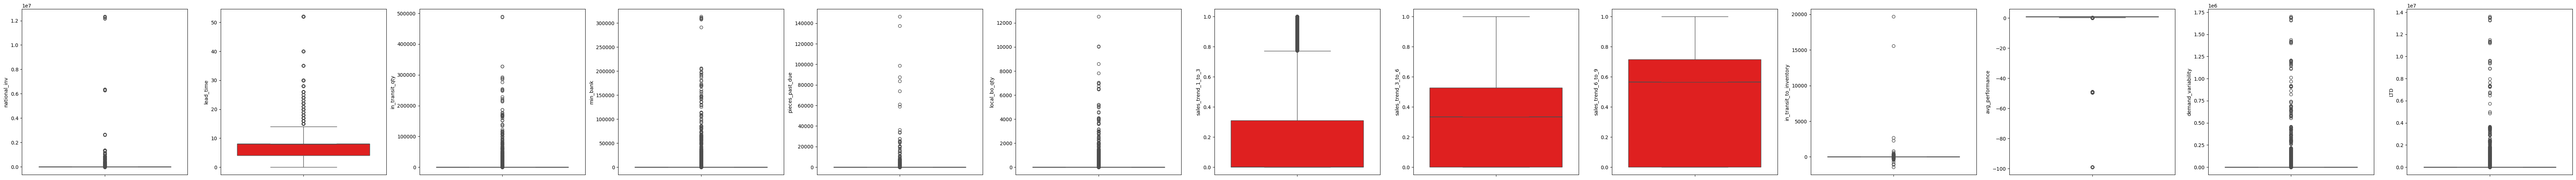

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(92,6))

# plotting
features = numerical
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='red',notch=True,vert=True)


In [ ]:
#All
for i in numerical:
  Q1 = train_df[i].quantile(0.25)
  Q3 = train_df[i].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = train_df[(train_df[i] < lower_bound) | (train_df[i] > upper_bound)]
  if outliers >= 1.5*IQR:
    max_non_outlier = train_df.loc[~train_df.index.isin(outliers.index), i].max()
    train_df.loc[outliers.index, i] = max_non_outlie
  elif outliers <= 1.5*IQR:
    min_non_outlier = train_df.loc[~train_df.index.isin(outliers.index), i].min()
    train_df.loc[outliers.index, i] = min_non_outlie

In [ ]:
column_data = df['total_of_special_requests']

Q1 = column_data.quantile(0.25)
Q3 = column_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(column_data < lower_bound) | (column_data > upper_bound)]

max_non_outlier = df.loc[~df.index.isin(outliers.index), 'total_of_special_requests'].max()
df.loc[outliers.index, 'total_of_special_requests'] = max_non_outlier

#Distribution

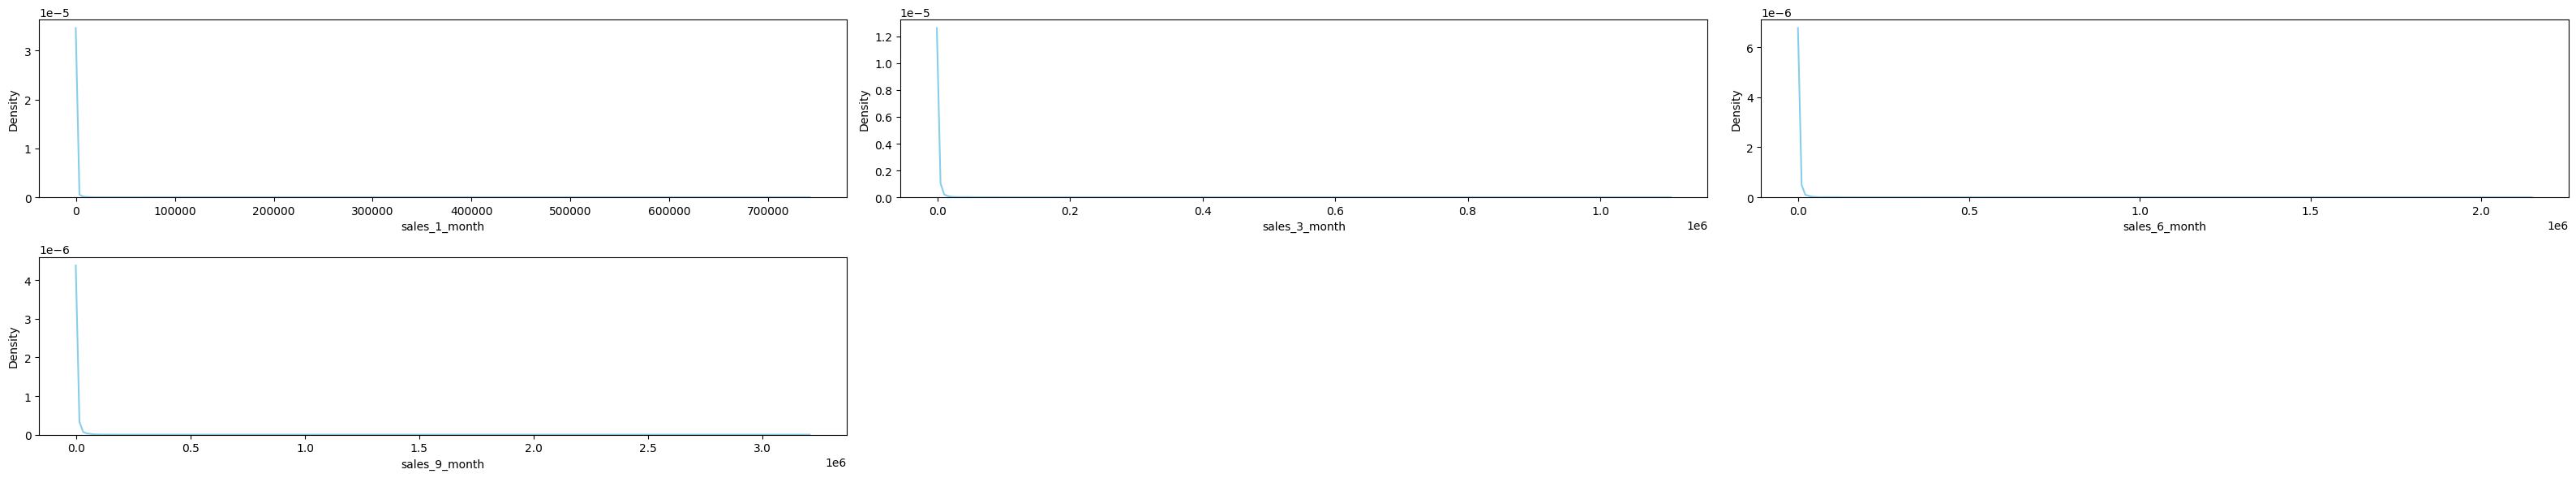

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(32,6))

features =  ['sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month']
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue')

    plt.xlabel(features[i])
    plt.tight_layout()

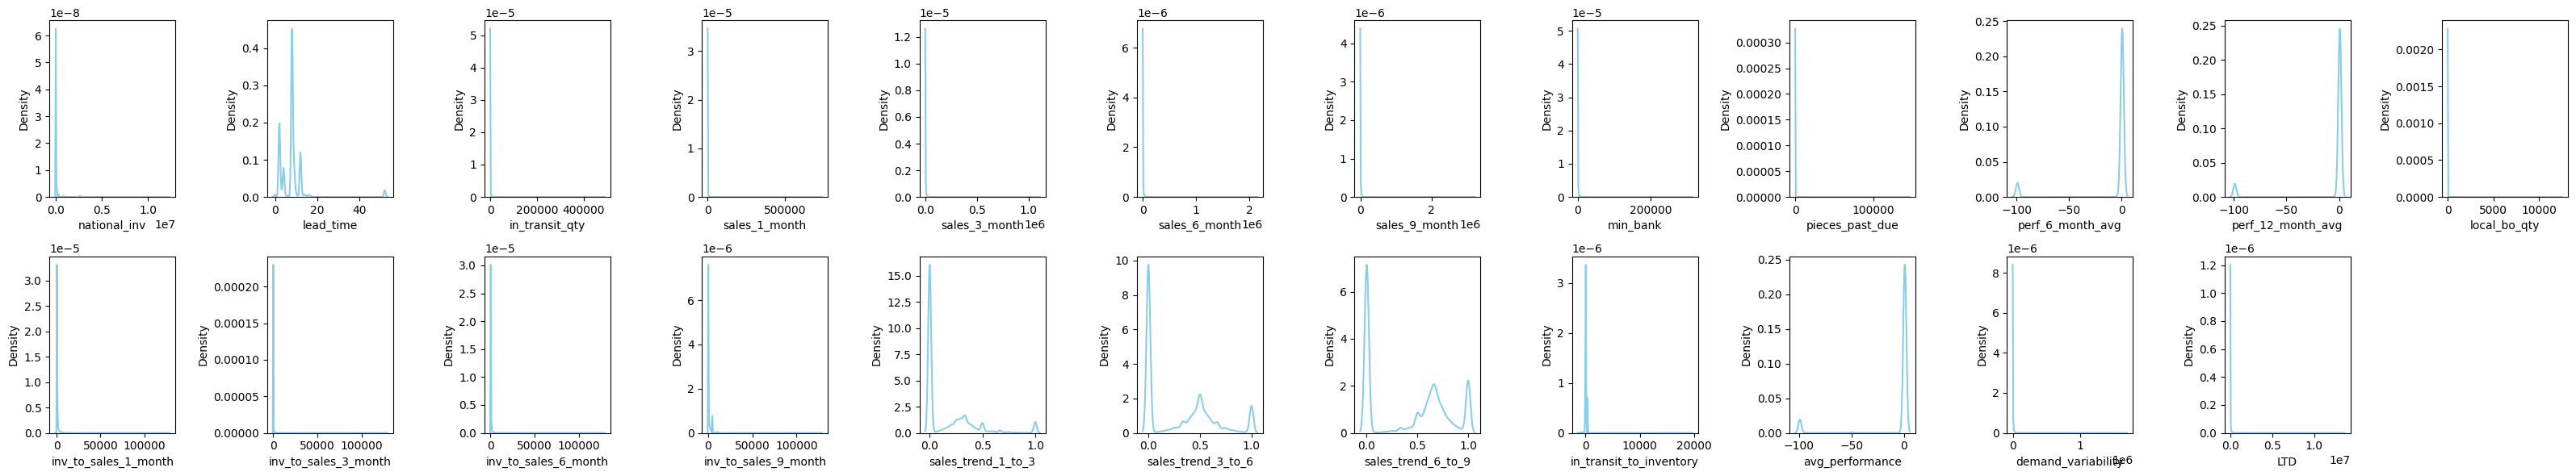

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(32,6))

features =  numerical
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue')
    # revised, histogram + kde
    plt.xlabel(features[i])
    plt.tight_layout()

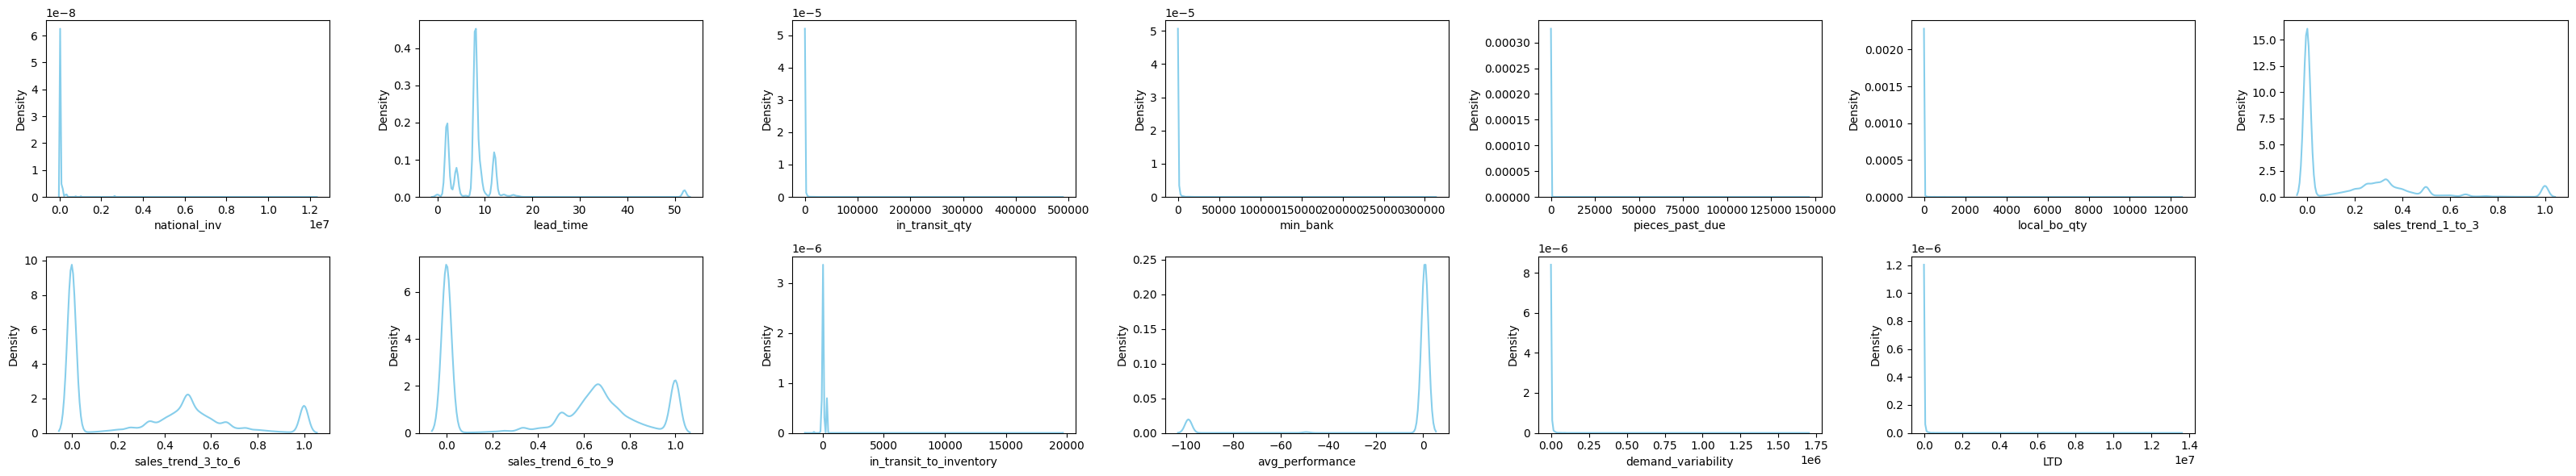

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(32,6))

features =  numerical
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue')
    # revised, histogram + kde
    plt.xlabel(features[i])
    plt.tight_layout()

#Encoding

In [ ]:
unique_value_counts = df[categorical].nunique()

print(unique_value_counts)

potential_issue      2
deck_risk            2
oe_constraint        2
ppap_risk            2
stop_auto_buy        2
rev_stop             2
went_on_backorder    2
dtype: int64


## One hot Encode

In [ ]:
encoded_data = pd.get_dummies(df, columns= ['potential_issue', 'deck_risk', 'oe_constraint','ppap_risk','stop_auto_buy','rev_stop','went_on_backorder'])
encoded_data.head()

,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD,potential_issue_No,potential_issue_Yes,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes,went_on_backorder_No,went_on_backorder_Yes
0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,True,False,True,False,True,False,True,False,False,True,True,False,True,False
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.990000,0.0,0.000000,True,False,True,False,True,False,True,False,False,True,True,False,True,False
2,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,True,False,False,True,True,False,True,False,False,True,True,False,True,False
3,7.0,8.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115000,0.0,0.000000,True,False,True,False,True,False,True,False,False,True,True,False,True,False
4,8.0,7.872267,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,1.0,7.872267,True,False,False,True,True,False,True,False,False,True,True,False,True,False


In [ ]:
encoded_data.drop(columns=['potential_issue_No', 'deck_risk_No', 'oe_constraint_No','ppap_risk_No','stop_auto_buy_No','rev_stop_No','went_on_backorder_No'],inplace=True)

In [ ]:
encoded_data.head()

,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,went_on_backorder_Yes
0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,False,False,False,False,True,False,False
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.990000,0.0,0.000000,False,False,False,False,True,False,False
2,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,False,True,False,False,True,False,False
3,7.0,8.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115000,0.0,0.000000,False,False,False,False,True,False,False
4,8.0,7.872267,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,1.0,7.872267,False,True,False,False,True,False,False


In [ ]:
cols = list(encoded_data.columns)
cols.insert(0, cols.pop(cols.index('went_on_backorder_Yes')))
encoded_data = encoded_data[cols]
encoded_data.head()

,went_on_backorder_Yes,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
0,False,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,False,False,False,False,True,False
1,False,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.990000,0.0,0.000000,False,False,False,False,True,False
2,False,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.000000,False,True,False,False,True,False
3,False,7.0,8.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115000,0.0,0.000000,False,False,False,False,True,False
4,False,8.0,7.872267,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,1.0,7.872267,False,True,False,False,True,False


In [ ]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 20 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   went_on_backorder_Yes    1687860 non-null  bool   
 1   national_inv             1687860 non-null  float64
 2   lead_time                1687860 non-null  float64
 3   in_transit_qty           1687860 non-null  float64
 4   min_bank                 1687860 non-null  float64
 5   pieces_past_due          1687860 non-null  float64
 6   local_bo_qty             1687860 non-null  float64
 7   sales_trend_1_to_3       1687860 non-null  float64
 8   sales_trend_3_to_6       1687860 non-null  float64
 9   sales_trend_6_to_9       1687860 non-null  float64
 10  in_transit_to_inventory  1687860 non-null  float64
 11  avg_performance          1687860 non-null  float64
 12  demand_variability       1687860 non-null  float64
 13  LTD                      1687860 non-null 

In [ ]:
encoded_int=encoded_data.copy()
to_int=['potential_issue_Yes','deck_risk_Yes','oe_constraint_Yes',	'ppap_risk_Yes'	,'stop_auto_buy_Yes'	,'rev_stop_Yes',	'went_on_backorder_Yes']
for i in to_int:
  encoded_int[i]=encoded_int[i].astype(int)


In [ ]:
encoded_int.head(3)

,went_on_backorder_Yes,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,sales_trend_1_to_3,sales_trend_3_to_6,sales_trend_6_to_9,in_transit_to_inventory,avg_performance,demand_variability,LTD,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
0,0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.0,0,0,0,0,1,0
1,0,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.990000,0.0,0.0,0,0,0,0,1,0
2,0,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779679,0.0,0.0,0,1,0,0,1,0


# Bivariate Analysis

##Corellation

<Axes: >

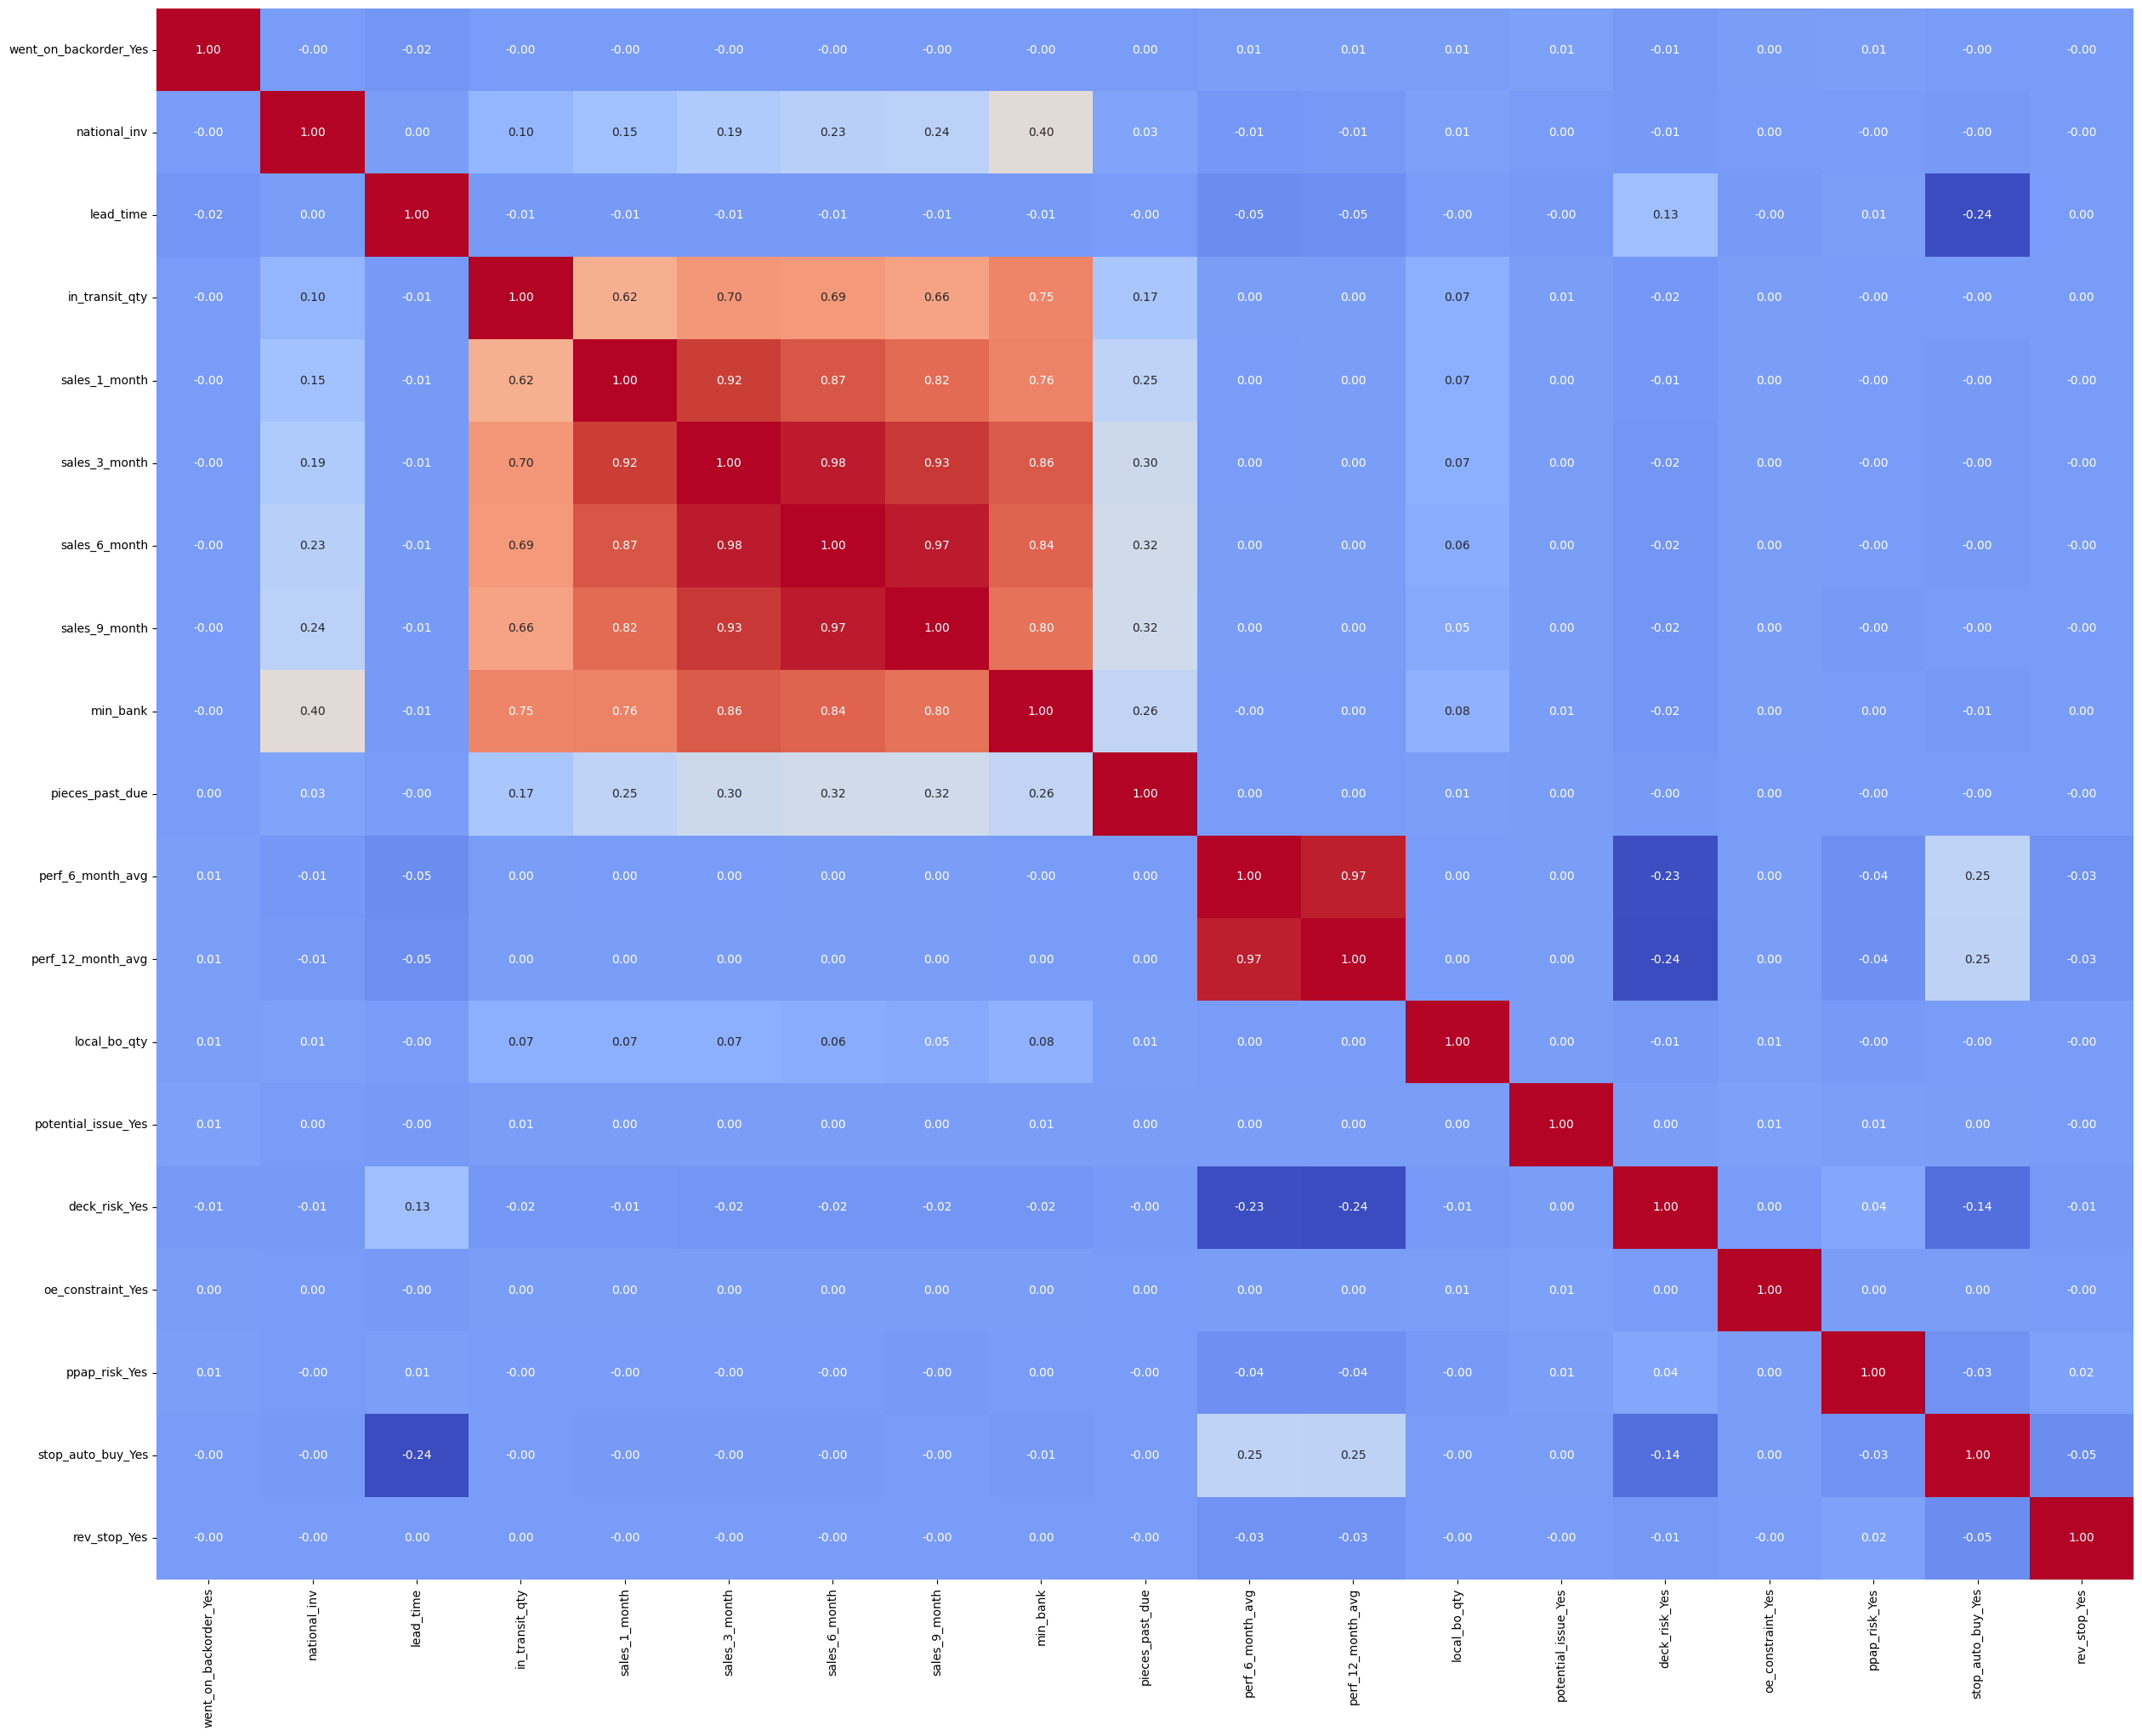

In [ ]:
# correlation heatmap basic
plt.figure(figsize=(30,24))
correlation = encoded_data.corr()


sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', cbar=False)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(encoded_int)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,went_on_backorder_Yes,1.001003
2,national_inv,1.541092
3,lead_time,1.074840
4,in_transit_qty,2.646855
5,sales_1_month,7.385064
6,sales_3_month,48.270187
7,sales_6_month,62.490407
8,sales_9_month,20.738407
9,min_bank,6.552367
10,pieces_past_due,1.138571


treshold :10

*   sales_n_month  have high multicol combine become 1

*   perf_6_month_avg and perf_12_month_avg have high corelation




<Axes: >

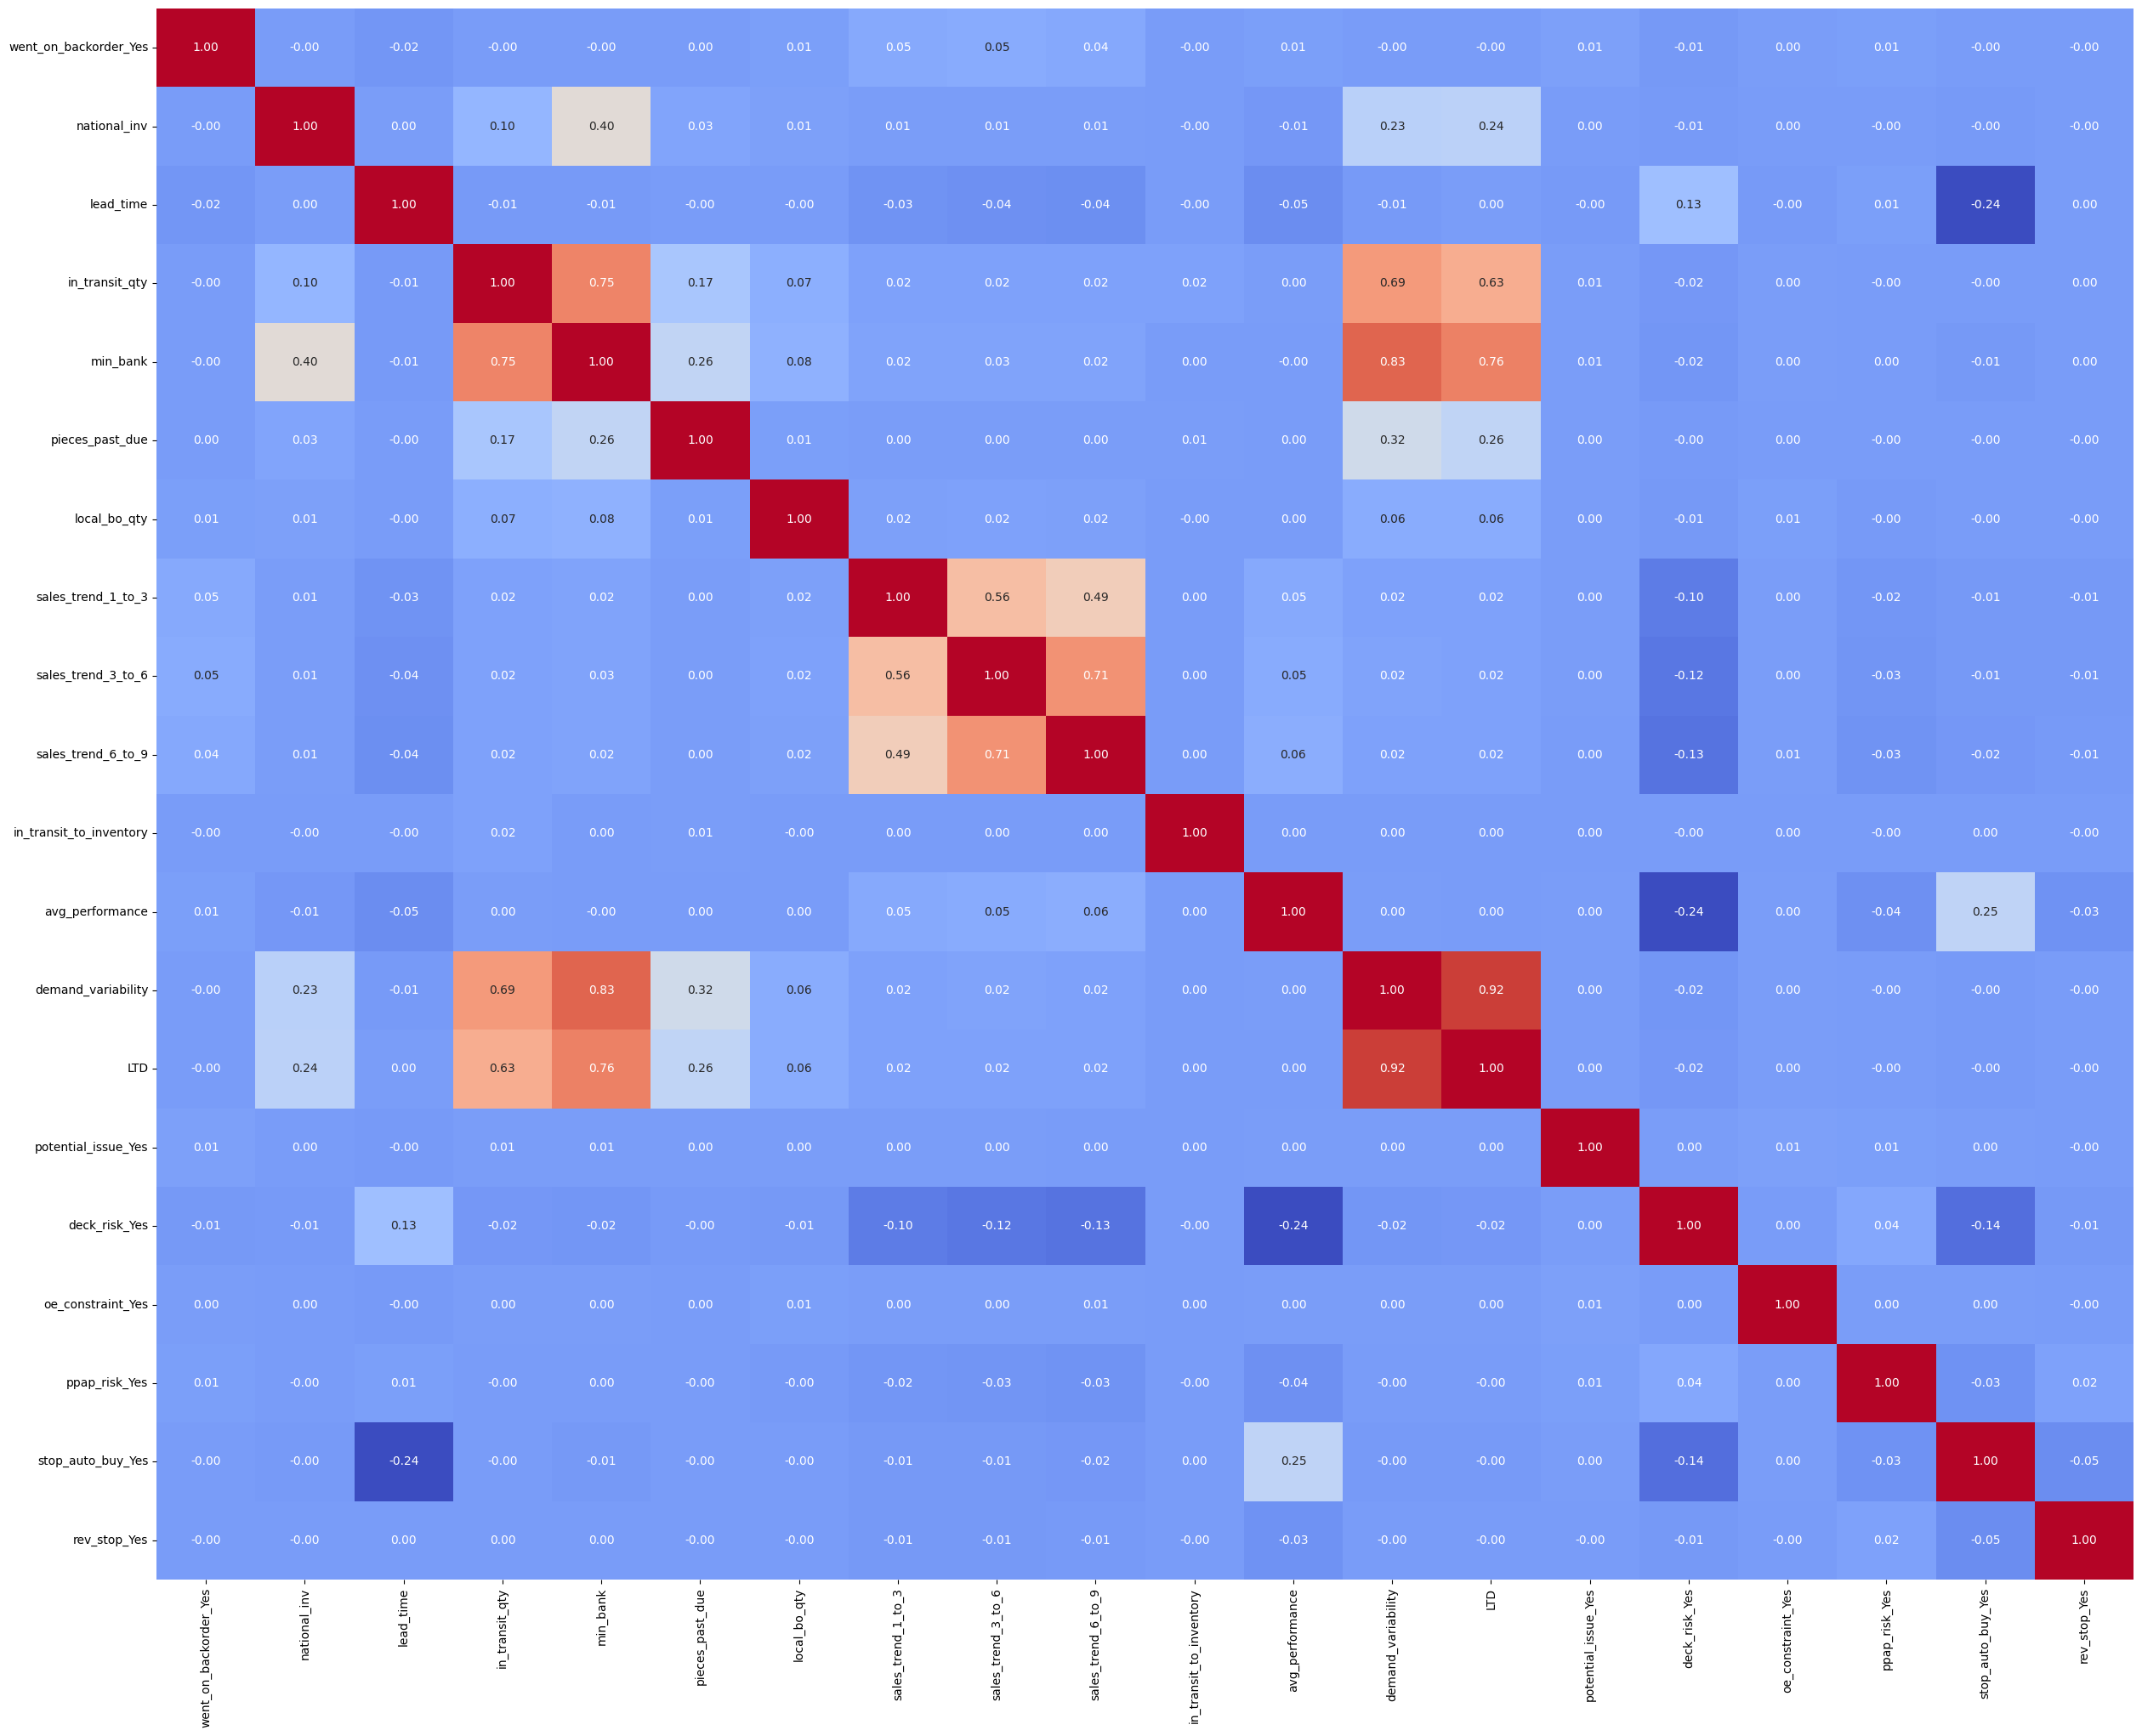

In [ ]:
# correlation heatmap after drop and add feature
plt.figure(figsize=(30,24))
correlation = encoded_data.corr()


sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', cbar=False)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(encoded_int)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,went_on_backorder_Yes,1.003982
2,national_inv,1.400406
3,lead_time,1.076877
4,in_transit_qty,2.627426
5,min_bank,5.382564
6,pieces_past_due,1.136887
7,local_bo_qty,1.007317
8,sales_trend_1_to_3,1.498981
9,sales_trend_3_to_6,2.308725
10,sales_trend_6_to_9,2.103208


### Imbalance check

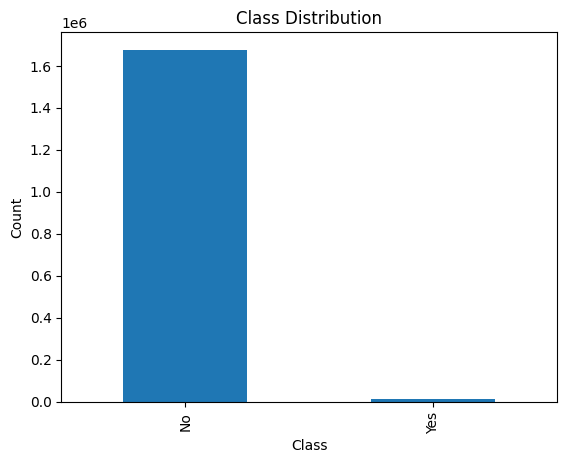

In [ ]:
df['went_on_backorder'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
class_counts=df["went_on_backorder"].value_counts()
print(class_counts)
imbalance=class_counts[0]/class_counts[1]
print(imbalance)

went_on_backorder
No     1676567
Yes      11293
Name: count, dtype: int64
148.46072788453023


Over Imbalance

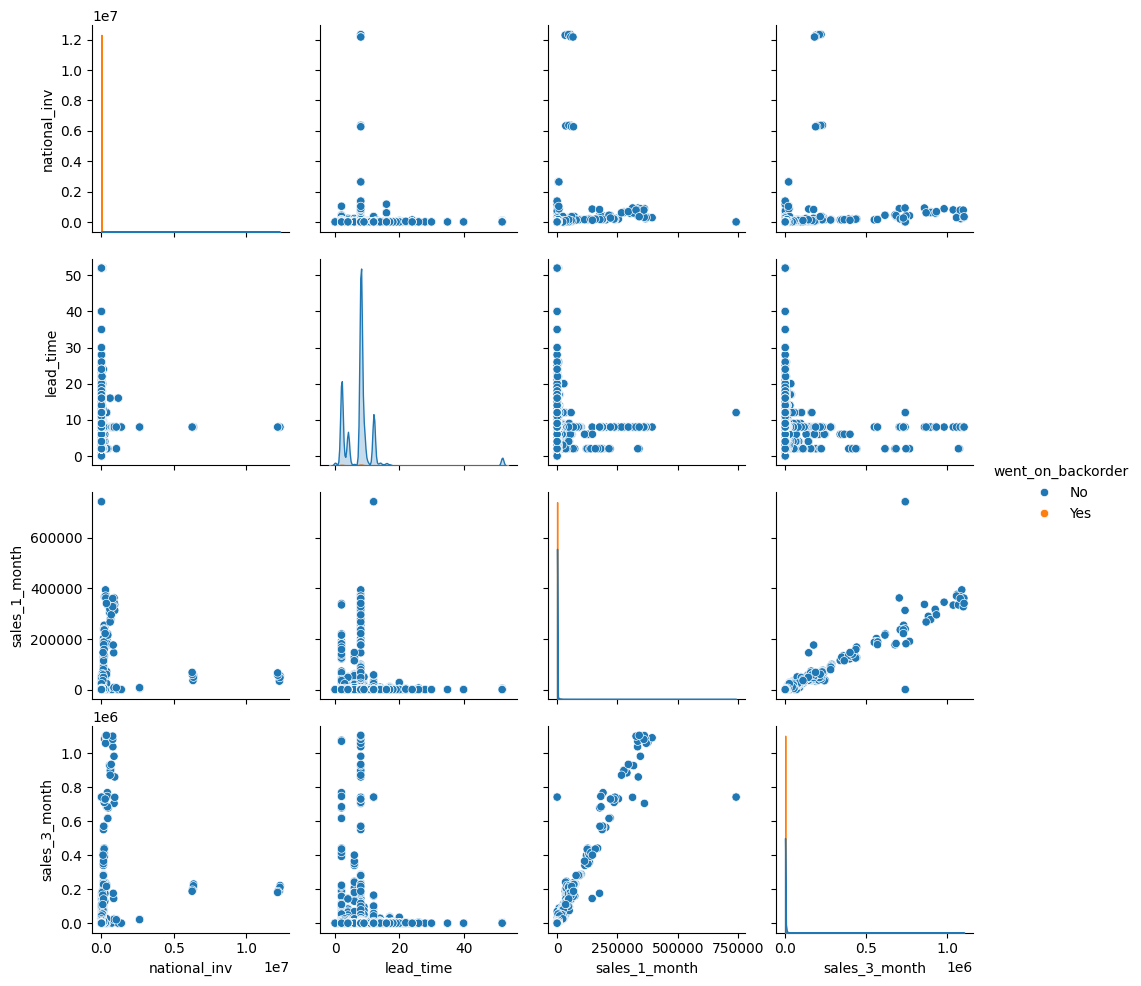

In [ ]:
selected_cols = ['national_inv', 'lead_time', 'sales_1_month', 'sales_3_month', 'went_on_backorder']
sns.pairplot(df[selected_cols], hue='went_on_backorder')
plt.show()

In [ ]:
selected_cols = ['national_inv',
 'lead_time',
 'in_transit_qty',
 'min_bank',
 'pieces_past_due',
 'local_bo_qty',
 'sales_trend_1_to_3',
 'sales_trend_3_to_6',
 'sales_trend_6_to_9',
 'in_transit_to_inventory',
 'avg_performance',
 'demand_variability',
 'LTD','went_on_backorder']
sns.pairplot(df[selected_cols], hue='went_on_backorder')
plt.show()

NameError: name 'sns' is not defined

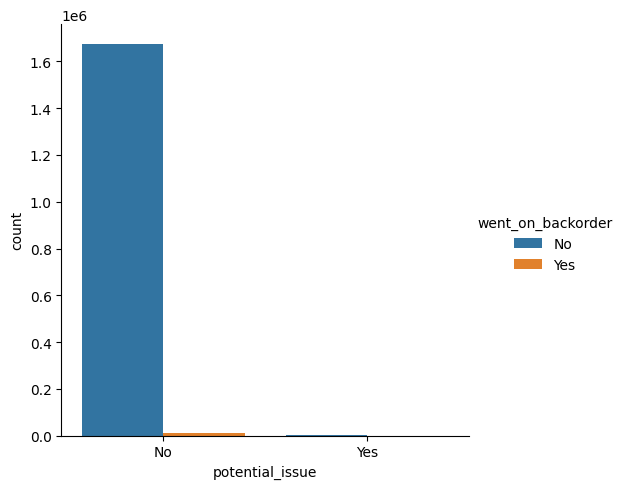

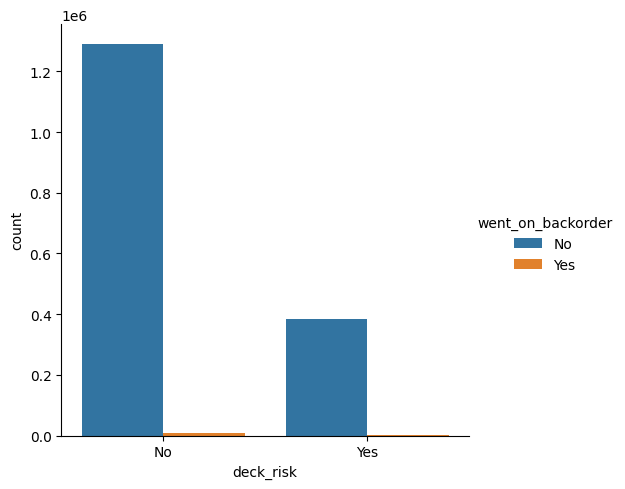

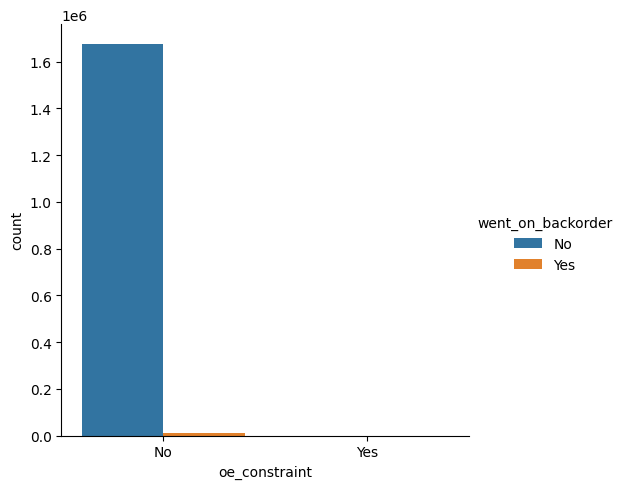

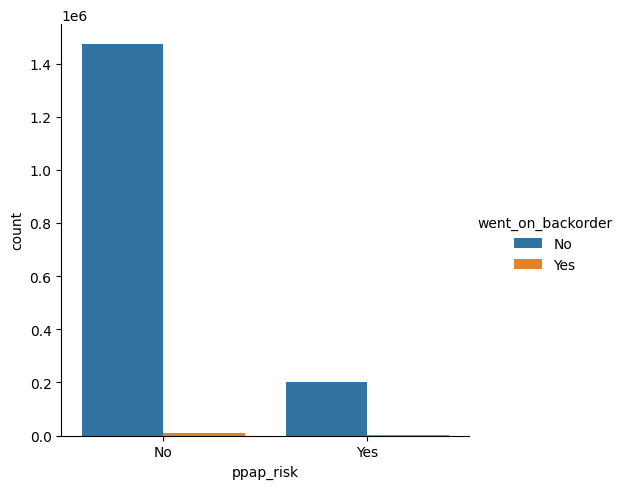

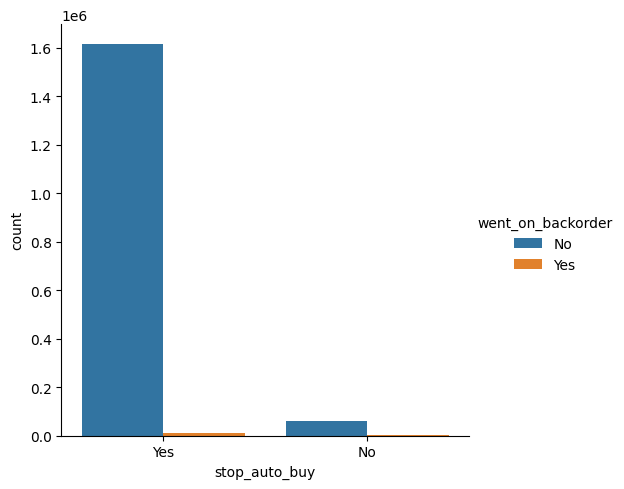

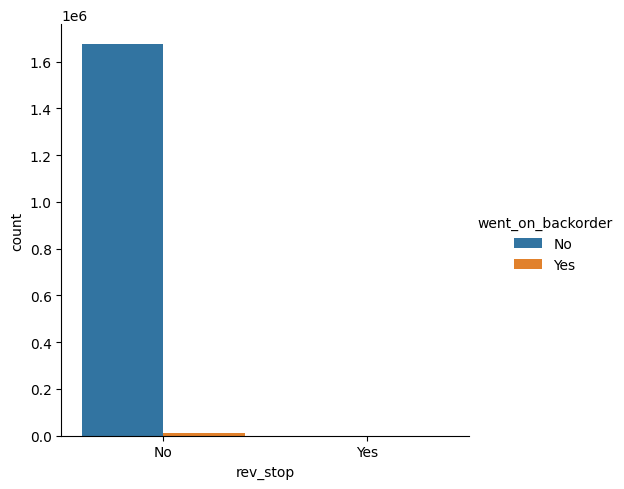

In [ ]:
selected_cols = ['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop']
for col in selected_cols:
  sns.catplot(x=col, hue='went_on_backorder', data=df, kind='count')
  plt.show()

#Modeling Back Order Detection

In [ ]:
# Split the data into features (X) and target variable (y)
X = encoded_data.drop(columns=['went_on_backorder_Yes'])
y = encoded_data['went_on_backorder_Yes']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
columns_to_scale = X_train.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_to_scale)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale)

In [ ]:
print(y_train.value_counts(normalize=True))

went_on_backorder_Yes
False    0.993381
True     0.006619
Name: proportion, dtype: float64


In [ ]:
# smote = SMOTE(sampling_strategy=1/140,random_state=42)
# X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_train_scaled, y_train)
# smote = SMOTE(sampling_strategy=1/70,random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled1, y_train_resampled1)




In [ ]:
smote = SMOTE(sampling_strategy=1,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
class_counts=y_train.value_counts()
print(class_counts)
imbalance=class_counts[0]/class_counts[1]
print(imbalance)

went_on_backorder_Yes
False    1173682
True        7820
Name: count, dtype: int64
150.08721227621484


In [ ]:
class_counts=y_train_resampled1.value_counts()
print(class_counts)
imbalance=class_counts[0]/class_counts[1]
print(imbalance)

went_on_backorder_Yes
False    1173682
True       58684
Name: count, dtype: int64
20.00003408083975


In [ ]:
class_counts=y_train_resampled.value_counts()
print(class_counts)
imbalance=class_counts[0]/class_counts[1]
print(imbalance)

went_on_backorder_Yes
False    1173682
True     1095436
Name: count, dtype: int64
1.071429093073443


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

##Basic

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier())])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.80      0.21      0.33      3473

    accuracy                           0.99    506358
   macro avg       0.90      0.60      0.66    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.68      0.08      0.14      3473

    accuracy                           0.99    506358
   macro avg       0.84      0.54      0.57    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.79095882522315
False Negative Rate for XGBoost: 0.9225453498416355
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or 

##Feature Add

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier())])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.81      0.17      0.28      3473

    accuracy                           0.99    506358
   macro avg       0.90      0.58      0.64    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.63      0.10      0.18      3473

    accuracy                           0.99    506358
   macro avg       0.81      0.55      0.59    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.832997408580478
False Negative Rate for XGBoost: 0.8951914771091276
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or

##Scalled+Smothe

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier())])
rf_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.00      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.50      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    502885
        True       0.04      0.08      0.05      3473

    accuracy                           0.98    506358
   macro avg       0.51      0.53      0.52    506358
weighted avg       0.99      0.98      0.98    506358

False Negative Rate for Random Forest: 1.0
False Negative Rate for XGBoost: 0.9222574143391881
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.


In [ ]:
# no sampling strategy
Random Forest:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.00      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.50      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.08      0.04      0.06      3473

    accuracy                           0.99    506358
   macro avg       0.54      0.52      0.53    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 1.0
False Negative Rate for XGBoost: 0.958537287647567
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.

False Negative Rate for Random Forest: 0.9988482579902102
False Negative Rate for XGBoost: 0.37949899222574146
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.

#sampling 1:140
Random Forest:
     precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.25      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.62      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.27      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.63      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.9985603224877627
False Negative Rate for XGBoost: 0.9982723869853153
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.
#1/140+1/70
Random Forest:
              precision    recall  f1-score   support

       False       0.94      0.01      0.03    502885
        True       0.01      0.87      0.01      3473

    accuracy                           0.02    506358
   macro avg       0.47      0.44      0.02    506358
weighted avg       0.93      0.02      0.03    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.75      0.85    502885
        True       0.01      0.38      0.02      3473

    accuracy                           0.75    506358
   macro avg       0.50      0.57      0.44    506358
weighted avg       0.99      0.75      0.85    506358

False Negative Rate for Random Forest: 0.13360207313561762
False Negative Rate for XGBoost: 0.6170457817448891
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data
#1/20+1/10
Random Forest:
              precision    recall  f1-score   support

       False       0.98      0.13      0.23    502885
        True       0.01      0.71      0.01      3473

    accuracy                           0.13    506358
   macro avg       0.50      0.42      0.12    506358
weighted avg       0.98      0.13      0.22    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.65      0.79    502885
        True       0.01      0.44      0.02      3473

    accuracy                           0.65    506358
   macro avg       0.50      0.54      0.40    506358
weighted avg       0.99      0.65      0.78    506358

False Negative Rate for Random Forest: 0.28793550244745175
False Negative Rate for XGBoost: 0.564065649294558
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.

Random Forest:
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
              precision    recall  f1-score   support

       False       0.99      0.92      0.95    502885
        True       0.01      0.11      0.02      3473

    accuracy                           0.91    506358
   macro avg       0.50      0.51      0.49    506358
weighted avg       0.99      0.91      0.95    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.20      0.04      0.07      3473

    accuracy                           0.99    506358
   macro avg       0.60      0.52      0.53    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.8937517995968903
False Negative Rate for XGBoost: 0.955369997120645
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.
                 False       0.99      0.83      0.90    502885
        True       0.00      0.06      0.01      3473

    accuracy                           0.83    506358
   macro avg       0.50      0.45      0.45    506358
weighted avg       0.99      0.83      0.90    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.20      0.04      0.07      3473

    accuracy                           0.99    506358
   macro avg       0.60      0.52      0.53    506358
weighted avg       0.99      0.99      0.99    506358
#1/10
Random Forest:
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.08      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.54      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.94      0.96    502885
        True       0.03      0.27      0.05      3473

    accuracy                           0.93    506358
   macro avg       0.51      0.60      0.51    506358
weighted avg       0.99      0.93      0.96    506358

False Negative Rate for Random Forest: 0.9988482579902102
False Negative Rate for XGBoost: 0.7333717247336596
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.

## Scalled Undersampled

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier())])
rf_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.16      0.09      0.11      3473

    accuracy                           0.99    506358
   macro avg       0.58      0.54      0.55    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.15      0.09      0.11      3473

    accuracy                           0.99    506358
   macro avg       0.57      0.54      0.55    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.9107399942412899
False Negative Rate for XGBoost: 0.9121796717535272
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting mo

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier(class_weight='balanced'))])
rf_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(scale_pos_weight=1676567/11293,use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.00      0.00      0.00      3473

    accuracy                           0.99    506358
   macro avg       0.50      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.85      0.92    502885
        True       0.01      0.27      0.02      3473

    accuracy                           0.85    506358
   macro avg       0.50      0.56      0.47    506358
weighted avg       0.99      0.85      0.91    506358

False Negative Rate for Random Forest: 1.0
False Negative Rate for XGBoost: 0.7330837892312122
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.


##Hyperparameter

In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, scoring='recall', cv=3, n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Use the best estimator found by GridSearchCV
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))



# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))


# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Best parameters found: ", grid_search_rf.best_params_)

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.21      0.05      0.08      3473

    accuracy                           0.99    506358
   macro avg       0.60      0.52      0.54    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.9513389000863807
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Best parameters found:  {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [ ]:
Random Forest:
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    502885
        True       0.21      0.05      0.08      3473

    accuracy                           0.99    506358
   macro avg       0.60      0.52      0.54    506358
weighted avg       0.99      0.99      0.99    506358

False Negative Rate for Random Forest: 0.9513389000863807
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Best parameters found:  {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

In [ ]:
# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__scale_pos_weight': [1, sum(y_train_resampled == 0) / sum(y_train_resampled == 1)]
}

grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid_xgb, scoring='recall', cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Use the best estimator found by GridSearchCV
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model

print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))
print("Best parameters found: ", grid_search_xgb.best_params_)

XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.92      0.95    502885
        True       0.02      0.26      0.04      3473

    accuracy                           0.91    506358
   macro avg       0.51      0.59      0.50    506358
weighted avg       0.99      0.91      0.95    506358

False Negative Rate for XGBoost: 0.7353872732507918
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.
Best parameters found:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 70.00369796015747}


In [ ]:
XGBoost:
              precision    recall  f1-score   support

       False       0.99      0.92      0.95    502885
        True       0.02      0.26      0.04      3473

    accuracy                           0.91    506358
   macro avg       0.51      0.59      0.50    506358
weighted avg       0.99      0.91      0.95    506358

False Negative Rate for XGBoost: 0.7353872732507918
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting more data.
Best parameters found:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 70.00369796015747}

##all


In [ ]:
# 1. Random Forest
print("Random Forest:")
rf_pipeline = Pipeline(steps=[
                              ('classifier', RandomForestClassifier(class_weight= 'balanced',
                                                                    max_depth= 10,
                                                                    min_samples_leaf= 2,
                                                                    min_samples_split= 2,
                                                                    n_estimators= 200))])
rf_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost
print("XGBoost:")
xgb_pipeline = Pipeline(steps=[
                               ('classifier', XGBClassifier(use_label_encoder=False,
                                                            eval_metric='logloss',
                                                            learning_rate= 0.1,
                                                            max_depth= 5,
                                                            n_estimators= 200,
                                                            scale_pos_weight= sum(y_train_resampled == 0) / sum(y_train_resampled == 1)))])
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Evaluasi tambahan: Confusion Matrix dan False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Menghitung dan mencetak False Negative Rate untuk masing-masing model
print("False Negative Rate for Random Forest:", false_negative_rate(y_test, y_pred_rf))
print("False Negative Rate for XGBoost:", false_negative_rate(y_test, y_pred_xgb))

# Rekomendasi berdasarkan False Negative Rate
def recommendation(fnr):
    if fnr > 0.1:
        return "The false negative rate is high. Consider improving the model or collecting more data."
    else:
        return "The false negative rate is acceptable."

print("Recommendation for Random Forest:", recommendation(false_negative_rate(y_test, y_pred_rf)))
print("Recommendation for XGBoost:", recommendation(false_negative_rate(y_test, y_pred_xgb)))

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       1.00      0.71      0.83    502885
        True       0.01      0.58      0.03      3473

    accuracy                           0.71    506358
   macro avg       0.50      0.65      0.43    506358
weighted avg       0.99      0.71      0.83    506358

XGBoost:
              precision    recall  f1-score   support

       False       1.00      0.59      0.74    502885
        True       0.01      0.64      0.02      3473

    accuracy                           0.59    506358
   macro avg       0.50      0.62      0.38    506358
weighted avg       0.99      0.59      0.74    506358

False Negative Rate for Random Forest: 0.4195220270659372
False Negative Rate for XGBoost: 0.35790382954218253
Recommendation for Random Forest: The false negative rate is high. Consider improving the model or collecting more data.
Recommendation for XGBoost: The false negative rate is high. Consider improving the model or collecting m

In [ ]:
import joblib
rf_model_path = '/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /RF_BackOrder.pkl'
xgb_model_path = '/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /XGB_BackOrder.pkl'
joblib.dump(rf_pipeline, rf_model_path)
joblib.dump(xgb_pipeline, xgb_model_path)

['/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /XGB_BackOrder.pkl']

#BO Feature Importance

Confusion Matrix for Random Forest:


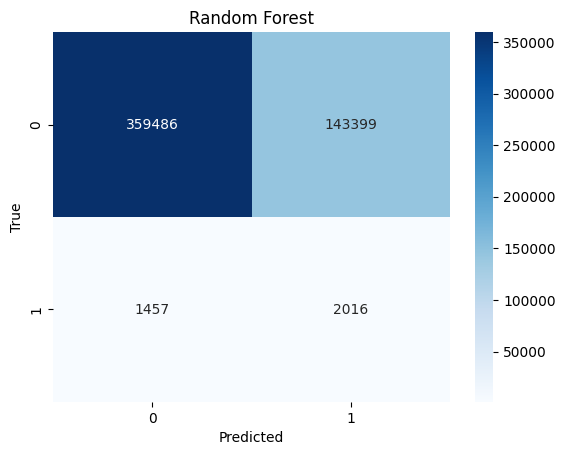

ROC AUC for Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


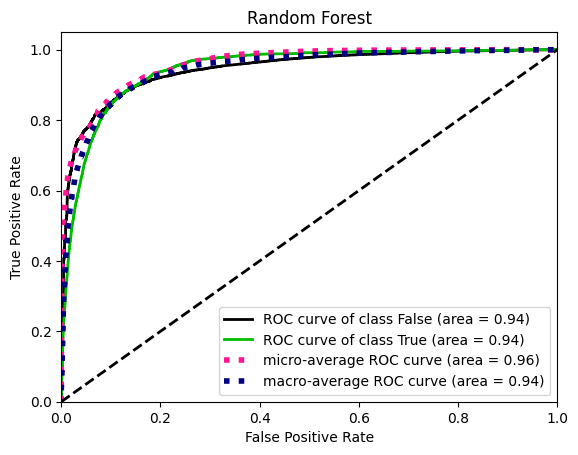

Confusion Matrix for XGBoost:


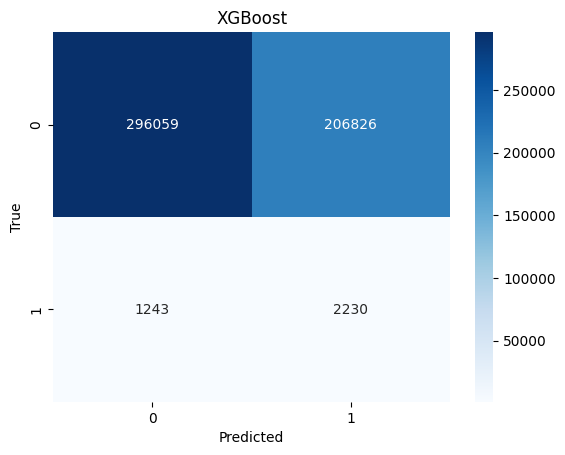

ROC AUC for XGBoost:


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


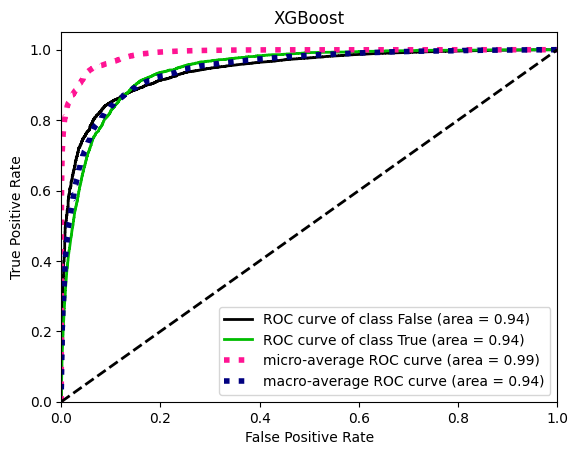

In [ ]:
np.random.seed(500)

# Fungsi untuk menampilkan Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Fungsi untuk menampilkan ROC Curve dan menghitung AUC
def plot_roc_auc(y_true, y_pred_prob, title):
    skplt.metrics.plot_roc_curve(y_true, y_pred_prob)
    plt.title(title)
    plt.show()

print("Confusion Matrix for Random Forest:")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
print("ROC AUC for Random Forest:")
plot_roc_auc(y_test, rf_pipeline.predict_proba(X_test_scaled), "Random Forest")

print("Confusion Matrix for XGBoost:")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
print("ROC AUC for XGBoost:")
plot_roc_auc(y_test, xgb_pipeline.predict_proba(X_test_scaled), "XGBoost")

In [ ]:
BO_rf_exp = dx.Explainer(rf_pipeline.named_steps['classifier'], X_train_scaled_df, y_train, label="RF Interpretation")
BO_xgb_exp = dx.Explainer(xgb_pipeline.named_steps['classifier'], X_train_scaled_df, y_train, label="XGB Interpretation")

rf_parts = BO_rf_exp.model_parts()
rf_parts.plot(title="Feature Importance for Random Forest")

xgb_parts = BO_xgb_exp.model_parts()
xgb_parts.plot(title="Feature Importance for XGBoost")

Preparation of a new explainer is initiated

  -> data              : 1181502 rows 19 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1181502 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RF Interpretation
  -> predict function  : <function yhat_proba_default at 0x7db3209f29e0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


  -> predicted values  : min = 0.0157, mean = 0.207, max = 0.981
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


  -> residuals         : min = -0.981, mean = -0.201, max = 0.971
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1181502 rows 19 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1181502 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB Interpretation
  -> predict function  : <function yhat_proba_default at 0x7db3209f29e0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.42e-05, mean = 0.106, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.991, mean = -0.0995, max = 0.994
  -> model_info        : package xgboost

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without

In [ ]:
BO_rf_exp.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

Calculating ceteris paribus:   5%|▌         | 1/19 [00:00<00:13,  1.30it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

Calculating ceteris paribus:  11%|█         | 2/19 [00:01<00:11,  1.49it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

Calculating ceteris paribus:  16%|█▌        | 3/19 [00:02<00:11,  1.42it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

Calculating ceteris paribus:  21%|██        | 4/19 [00:02<00:10,  1.38it/s]/usr/

In [ ]:
BO_xgb_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]


In [15]:
import joblib
xgb_model = joblib.load('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /XGB_BackOrder.pkl')
rf_model = joblib.load('/content/drive/MyDrive/DS 24_Satrio Bayu_Progress Final Project /RF_BackOrder.pkl')

In [18]:
X = test_df.drop('went_on_backorder', axis=1)
y = test_df['went_on_backorder']

In [19]:
y_pred_rf = rf_model.predict(X)
y_pred_xgb = xgb_model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: '(242075 rows)'

In [ ]:
rf_model.fit(X,y)
xgb_model.fit(X,y)

encoded_data['xgb_pred_prob'] = xgb_model.predict_proba(X)[:, 1]
encoded_data['rf_pred_prob'] = rf_model.predict_proba(X)[:, 1]

In [ ]:
threshold = 0.5
encoded_data['xgb_predicted_backorder'] = encoded_data['xgb_pred_prob'] >= threshold
encoded_data['rf_predicted_backorder'] = encoded_data['rf_pred_prob'] >= threshold

XGBoost Predictions:
                         national_inv                                       \
                               count          mean           std      min   
xgb_predicted_backorder                                                     
False                      1687852.0    496.020073  29615.261905 -27256.0   
True                             8.0  19845.000000  13173.700370  -1037.0   

                                                                 lead_time  \
                              25%      50%      75%         max      count   
xgb_predicted_backorder                                                      
False                        4.00     15.0     80.0  12334404.0  1687852.0   
True                     13082.25  27946.0  28590.0     29332.0        8.0   

                                                                       \
                             mean       std  min  25%  50%  75%   max   
xgb_predicted_backorder                                

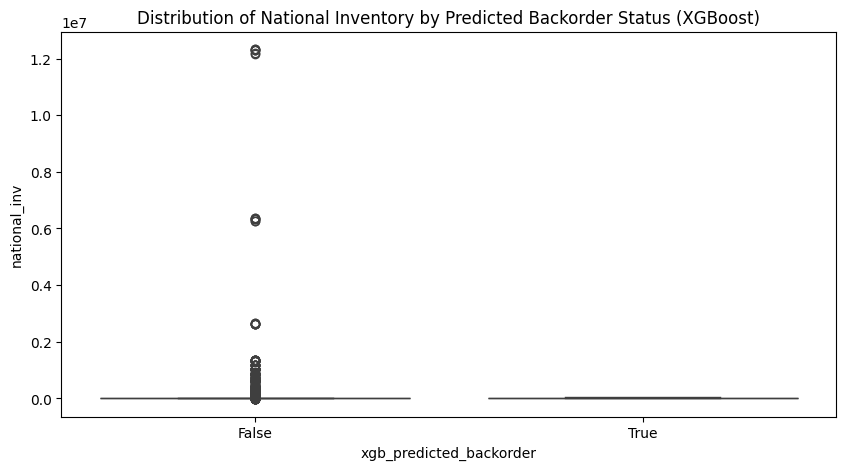

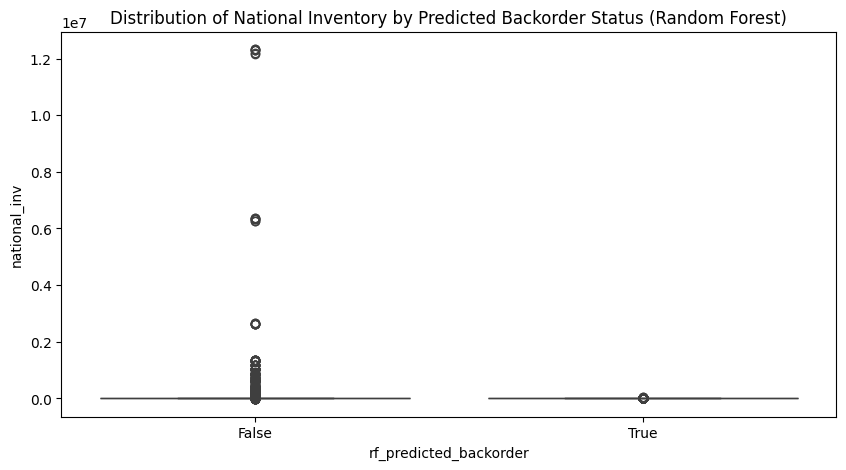

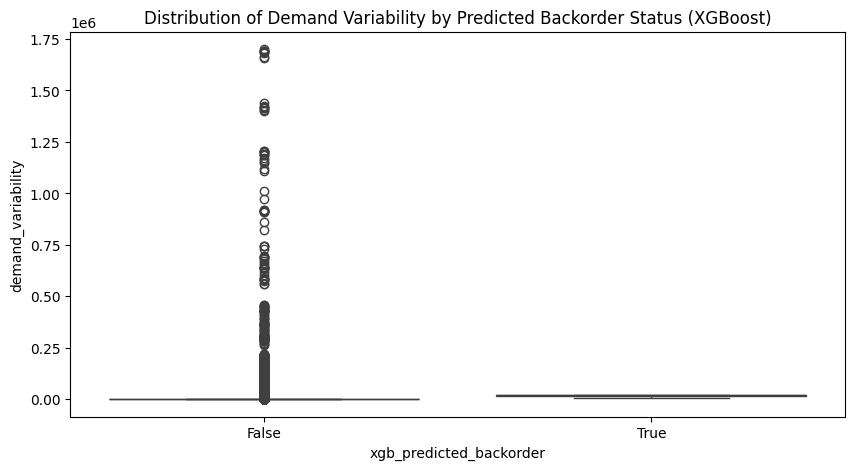

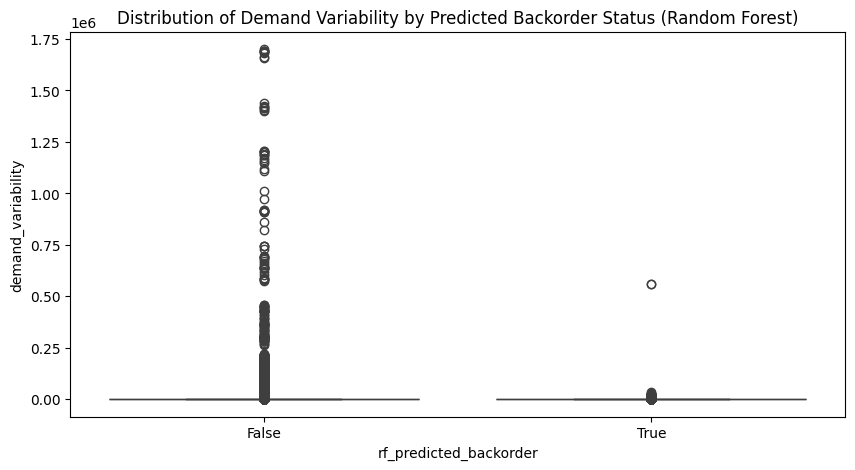

In [ ]:
xgb_grouped_pred = encoded_data.groupby('xgb_predicted_backorder').describe()
rf_grouped_pred = encoded_data.groupby('rf_predicted_backorder').describe()

print("XGBoost Predictions:\n", xgb_grouped_pred)
print("Random Forest Predictions:\n", rf_grouped_pred)

plt.figure(figsize=(10, 5))
sns.boxplot(x='xgb_predicted_backorder', y='national_inv', data=encoded_data)
plt.title('Distribution of National Inventory by Predicted Backorder Status (XGBoost)')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='rf_predicted_backorder', y='national_inv', data=encoded_data)
plt.title('Distribution of National Inventory by Predicted Backorder Status (Random Forest)')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='xgb_predicted_backorder', y='demand_variability', data=encoded_data)
plt.title('Distribution of Demand Variability by Predicted Backorder Status (XGBoost)')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='rf_predicted_backorder', y='demand_variability', data=encoded_data)
plt.title('Distribution of Demand Variability by Predicted Backorder Status (Random Forest)')
plt.show()

#Modeling Lead Time Reduce

##Split Data

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into features (X) and target variable (y)
X_lead_time = encoded_int.drop(columns=['lead_time'])
y_lead_time = encoded_int['lead_time']

# Split the dataset into training and testing sets
X_train_lt, X_test_lt, y_train_lt, y_test_lt = train_test_split(X_lead_time, y_lead_time, test_size=0.3, random_state=42)

In [ ]:
columns_to_scale = X_train_lt.columns.tolist()

scaler = StandardScaler()
X_train_lt_scaled = scaler.fit_transform(X_train_lt)

X_test_lt_scaled = scaler.transform(X_test_lt)

##basic

In [ ]:
# 1. Linear Regression
print("Linear Regression:")
lr_pipeline = Pipeline(steps=[
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train_lt, y_train_lt)
y_pred_lr = lr_pipeline.predict(X_test_lt)


# 2. Random Forest Regressor
print("Random Forest Regressor:")
rf_pipeline = Pipeline(steps=[
                              ('regressor', RandomForestRegressor())])
rf_pipeline.fit(X_train_lt, y_train_lt)
y_pred_rf = rf_pipeline.predict(X_test_lt)


# Evaluasi tambahan: MAE,MAPE,RMSE
def mae_lt(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae
def mape_lt(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape
def rmse_lt(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Menghitung dan mencetak MAE, MAPE, RMSE untuk masing-masing model
print("MAE for Linear Regression:", mae_lt(y_test_lt, y_pred_lr))
print("MAE for Random Forest Regressor:", mae_lt(y_test_lt, y_pred_rf))
print("MAPE for Linear Regression:", mape_lt(y_test_lt, y_pred_lr))
print("MAPE for Random Forest Regressor:", mape_lt(y_test_lt, y_pred_rf))
print("RMSE for Linear Regression:", rmse_lt(y_test_lt, y_pred_lr))
print("RMSE for Random Forest Regressor:", rmse_lt(y_test_lt, y_pred_rf))


Linear Regression:
Random Forest Regressor:
MAE for Linear Regression: 3.6197773812470038
MAE for Random Forest Regressor: 1.323590129391558
MAPE for Linear Regression: 372320467605747.1
MAPE for Random Forest Regressor: 24808939104132.887
RMSE for Linear Regression: 6.568522088650553
RMSE for Random Forest Regressor: 3.1025515759060602


Multico handle

In [ ]:
# 1. Linear Regression
print("Linear Regression:")
lr_pipeline = Pipeline(steps=[
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train_lt, y_train_lt)
y_pred_lr = lr_pipeline.predict(X_test_lt)


# 2. Random Forest Regressor
print("Random Forest Regressor:")
rf_pipeline = Pipeline(steps=[
                              ('regressor', RandomForestRegressor())])
rf_pipeline.fit(X_train_lt, y_train_lt)
y_pred_rf = rf_pipeline.predict(X_test_lt)


# Evaluasi tambahan: MAE,MAPE,RMSE
def mae_lt(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae
def mape_lt(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape
def rmse_lt(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Menghitung dan mencetak MAE, MAPE, RMSE untuk masing-masing model
print("MAE for Linear Regression:", mae_lt(y_test_lt, y_pred_lr))
print("MAE for Random Forest Regressor:", mae_lt(y_test_lt, y_pred_rf))
print("MAPE for Linear Regression:", mape_lt(y_test_lt, y_pred_lr))
print("MAPE for Random Forest Regressor:", mape_lt(y_test_lt, y_pred_rf))
print("RMSE for Linear Regression:", rmse_lt(y_test_lt, y_pred_lr))
print("RMSE for Random Forest Regressor:", rmse_lt(y_test_lt, y_pred_rf))


Linear Regression:
Random Forest Regressor:
MAE for Linear Regression: 3.5997863700597628
MAE for Random Forest Regressor: 0.5095903520233573
MAPE for Linear Regression: 371712874995379.5
MAPE for Random Forest Regressor: 10969091927573.47
RMSE for Linear Regression: 6.56308159462914
RMSE for Random Forest Regressor: 2.0730890273125624


In [ ]:
# 1. Linear Regression
print("Linear Regression:")
lr_pipeline = Pipeline(steps=[
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train_lt, y_train_lt)
y_pred_lr = lr_pipeline.predict(X_test_lt)


# 2. Random Forest Regressor
print("Random Forest Regressor:")
rf_pipeline = Pipeline(steps=[
                              ('regressor', RandomForestRegressor())])
rf_pipeline.fit(X_train_lt, y_train_lt)
y_pred_rf = rf_pipeline.predict(X_test_lt)


# Evaluasi tambahan: MAE,MAPE,RMSE
def mae_lt(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae
def mape_lt(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape
def rmse_lt(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Menghitung dan mencetak MAE, MAPE, RMSE untuk masing-masing model
print("MAE for Linear Regression:", mae_lt(y_test_lt, y_pred_lr))
print("MAE for Random Forest Regressor:", mae_lt(y_test_lt, y_pred_rf))
print("MAPE for Linear Regression:", mape_lt(y_test_lt, y_pred_lr))
print("MAPE for Random Forest Regressor:", mape_lt(y_test_lt, y_pred_rf))
print("RMSE for Linear Regression:", rmse_lt(y_test_lt, y_pred_lr))
print("RMSE for Random Forest Regressor:", rmse_lt(y_test_lt, y_pred_rf))


Linear Regression:
Random Forest Regressor:
MAE for Linear Regression: 3.609301081411298
MAE for Random Forest Regressor: 0.509933290724963
MAPE for Linear Regression: 346792675769760.0
MAPE for Random Forest Regressor: 11151880617489.346
RMSE for Linear Regression: 6.564823249134806
RMSE for Random Forest Regressor: 2.073307234844983


#Modeling Forecasting

## Arima

In [ ]:
print("ARIMA:")
arima_order = (5, 1, 0)  # Contoh parameter (p, d, q)
arima_model = ARIMA(y_train_lt, order=arima_order)
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(y_test_lt))

print("MAE for ARIMA:", mean_absolute_error(y_test_lt, y_pred_arima))
print("MAPE for ARIMA:", mean_absolute_percentage_error(y_test_lt, y_pred_arima))
print("RMSE for ARIMA:", np.sqrt(mean_squared_error(y_test_lt, y_pred_arima)))

In [ ]:
print("Exponential Smoothing (ETS):")
ets_model = ExponentialSmoothing(y_train_lt, trend='add', seasonal='add', seasonal_periods=4)  # Misal data kuartalan
ets_model_fit = ets_model.fit()
y_pred_ets = ets_model_fit.forecast(steps=len(y_test_lt))

print("MAE for ETS:", mean_absolute_error(y_test_lt, y_pred_ets))
print("MAPE for ETS:", mean_absolute_percentage_error(y_test_lt, y_pred_ets))
print("RMSE for ETS:", np.sqrt(mean_squared_error(y_test_lt, y_pred_ets)))